## Communicating Data Findings: US Flights (2008)
Author: Piyush Kumar

### Table of Contents:

- [Introduction](#intro)
- [Data Wrangling](#wrangle)
- [Univariate Analysis](#univariate)
- [Bivariate Analysis](#bivariate)
- [Multivariate Analysis](#multivariate)


<a id=intro></a>
### Introduction:  

Have you ever been stuck in an airport because your flight was delayed or cancelled and wondered if you could have predicted it if you'd had more data? 

Let's dig into one such dataset that reports flights in the United States, including carriers, arrival and departure delays, and reasons for delays, from October 1987 to April 2008. This is a [large dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7), there are nearly 120 million records in total, and takes up 1.6 gigabytes of space compressed and 12 gigabbytes when uncompressed. <br>
Due to computational resource limitations, I'll be will be using the data for the year 2008 only, which is around 7 million rows.  

[Another Source for this Data](https://www.kaggle.com/vikalpdongre/us-flights-data-2008)

#### The Data: 

- <b>Flights Data:</b>  The data consists of flight arrival and departure details for all commercial flights within the USA, for the year 2008.  
- <b> Airports Data:</b> This describes the locations of US airports, with the fields:the international airport abbreviation code, name of the airport, city and country in which airport is located, and the latitude and longitude of the airport.
- <b> Carriers Data:</b> This contains listing of carrier codes with full names.
- <b> Planes Data:</b> It contains information on plane manufacturers, model, aircraft type, engine type etc.


To get started let's import our libraries:

In [1]:
import IPython
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from timeit import default_timer as timer

# let's set up a random seed as well just in case we might need them
np.random.seed(42)

In [2]:
# let's load our datasets.

# Note: we have few time columns in the flights dataset which might be inferred as float/int by pandas upon reading the dataset, 
# so let's tell pandas to load it as a string untouched from the beginning and switch off this float/int inference entirely.

flights=pd.read_csv("2008.csv", dtype={'DepTime':str, "CRSDepTime":str, "ArrTime":str,
                                       "CRSArrTime":str, "ActualElapsedTime":str, "CRSElapsedTime": str}) 
airports=pd.read_csv("airports.csv")
airlines=pd.read_csv("carriers.csv")
planes=pd.read_csv("plane-data.csv")

In [3]:
# let's look into the loaded datasets.

flights.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003,1955,2211,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754,735,1002,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628,620,804,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926,930,1054,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829,1755,1959,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


<a id='wrangle'></a>
### Data Wrangling:

We will be doing minimal Data Wrangling for now, more on as and whenever required along the analysis.

In [4]:
flights.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 7009728 non-null int64
Month                7009728 non-null int64
DayofMonth           7009728 non-null int64
DayOfWeek            7009728 non-null int64
DepTime              6873482 non-null object
CRSDepTime           7009728 non-null object
ArrTime              6858079 non-null object
CRSArrTime           7009728 non-null object
UniqueCarrier        7009728 non-null object
FlightNum            7009728 non-null int64
TailNum              6926363 non-null object
ActualElapsedTime    6855029 non-null object
CRSElapsedTime       7008884 non-null object
AirTime              6855029 non-null float64
ArrDelay             6855029 non-null float64
DepDelay             6873482 non-null float64
Origin               7009728 non-null object
Dest                 7009728 non-null object
Distance             7009728 non-null int64
TaxiIn               6858079 non-nu

Note, that the memory usage with just one year data is more than 1.5GB, incorporating data from all years would have definitely needed better computational resource at hand. I wished to have the AWS EC2 instance for this analysis and use the data from all the years and do a more rigorous analysis. Neverthless, another time!  

**Let's understand more about these column variables.**

- **Year:** 2008
- **Month:**	12-Jan
- **DayofMonth:**	31-Jan
- **DayOfWeek:**	1 (Monday) - 7 (Sunday)
- **DepTime:**	actual departure time (local, hhmm)
- **CRSDepTime:**	scheduled departure time (local, hhmm)
- **ArrTime:**	actual arrival time (local, hhmm)
- **CRSArrTime:**	scheduled arrival time (local, hhmm)
- **UniqueCarrier:**	unique carrier code
- **FlightNum:**	flight number
- **TailNum:**	plane tail number
- **ActualElapsedTime:**	in minutes
- **CRSElapsedTime:**	in minutes
- **AirTime:**	in minutes
- **ArrDelay:**	arrival delay, in minutes
- **DepDelay:**	departure delay, in minutes
- **Origin:**	origin IATA airport code
- **Dest:**	destination IATA airport code
- **Distance:**	in miles
- **TaxiIn:**	taxi in time, in minutes
- **TaxiOut:**	taxi out time in minutes
- **Cancelled:**	was the flight cancelled?
- **CancellationCode:**	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
- **Diverted:**	1 = yes, 0 = no
- **CarrierDelay:**	in minutes
- **WeatherDelay:**	in minutes
- **NASDelay:**	in minutes (NAS: National Airspace System)
- **SecurityDelay:**	in minutes
- **LateAircraftDelay:**	in minutes

**Let's do few basic checks on this main dataset.**

In [5]:
# Total Flight observations we have:

flights.shape

(7009728, 29)

In [6]:
flights.duplicated().sum()

4

In [7]:
flights.drop_duplicates(inplace=True)
flights.duplicated().sum()

0

In [8]:
flights.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               136246
CRSDepTime                 0
ArrTime               151649
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                83365
ActualElapsedTime     154699
CRSElapsedTime           844
AirTime               154699
ArrDelay              154699
DepDelay              136246
Origin                     0
Dest                       0
Distance                   0
TaxiIn                151649
TaxiOut               137058
Cancelled                  0
CancellationCode     6872290
Diverted                   0
CarrierDelay         5484991
WeatherDelay         5484991
NASDelay             5484991
SecurityDelay        5484991
LateAircraftDelay    5484991
dtype: int64

In [9]:
# let's have a look into other datasets as well. 
airports.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


- iata: International Airport Abbreviation Code

In [10]:
airlines.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


- Code: this is carrier code.

In [11]:
planes.head()

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
0,N050AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N051AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N052AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N054AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N055AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# let's merge the flights, airlines and planes datasets on appropriate columns. 

df=pd.merge(flights,airlines, left_on='UniqueCarrier', right_on= 'Code', how='left')
df=pd.merge(df,planes, left_on='TailNum', right_on='tailnum', how='left')
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Description,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
0,2008,1,3,4,2003,1955,2211,2225,WN,335,...,Southwest Airlines Co.,N712SW,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998
1,2008,1,3,4,754,735,1002,1000,WN,3231,...,Southwest Airlines Co.,N772SW,Corporation,BOEING,08/07/2000,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2000
2,2008,1,3,4,628,620,804,750,WN,448,...,Southwest Airlines Co.,N428WN,Corporation,BOEING,12/20/2002,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2002
3,2008,1,3,4,926,930,1054,1100,WN,1746,...,Southwest Airlines Co.,N612SW,Corporation,BOEING,11/01/1995,737-3H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1995
4,2008,1,3,4,1829,1755,1959,1925,WN,3920,...,Southwest Airlines Co.,N464WN,Corporation,BOEING,07/23/2004,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004


In [13]:
# Let's change the time format of 'DepTime','CRSDepTime','ArrTime' and 'CRSArrTime' columns.

def format_time(x):
    temp = x.str.zfill(4)
    return pd.to_timedelta(temp.str[:2] + ':' + temp.str[2:] + ':00')

time_variables=['DepTime','CRSDepTime','ArrTime','CRSArrTime']

df[time_variables] = df[time_variables].apply(format_time)
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Description,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
0,2008,1,3,4,20:03:00,19:55:00,22:11:00,22:25:00,WN,335,...,Southwest Airlines Co.,N712SW,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998
1,2008,1,3,4,07:54:00,07:35:00,10:02:00,10:00:00,WN,3231,...,Southwest Airlines Co.,N772SW,Corporation,BOEING,08/07/2000,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2000
2,2008,1,3,4,06:28:00,06:20:00,08:04:00,07:50:00,WN,448,...,Southwest Airlines Co.,N428WN,Corporation,BOEING,12/20/2002,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2002
3,2008,1,3,4,09:26:00,09:30:00,10:54:00,11:00:00,WN,1746,...,Southwest Airlines Co.,N612SW,Corporation,BOEING,11/01/1995,737-3H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1995
4,2008,1,3,4,18:29:00,17:55:00,19:59:00,19:25:00,WN,3920,...,Southwest Airlines Co.,N464WN,Corporation,BOEING,07/23/2004,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004


<a id='univariate'></a>
### Univariate Analysis:

### Which airline runs the most flights?

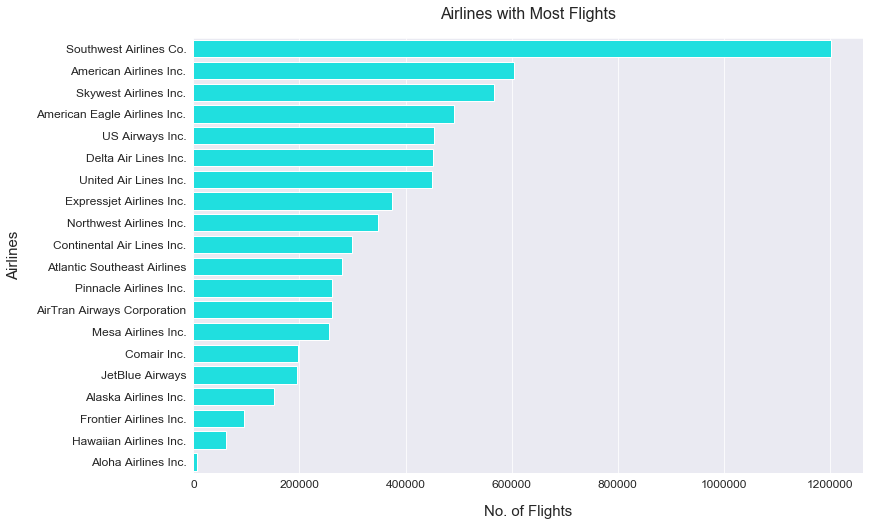

In [14]:
# We have a very long string for one of the airline name, not suitable to visualizations. let's change that.
df.Description.replace("US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)",
                       "US Airways Inc.", inplace=True)

plt.figure(figsize=(12,8))
sns.set_style('darkgrid')

sns.barplot(x=df.Description.value_counts(), 
            y=df.Description.value_counts().index, palette=["aqua"])

plt.title("Airlines with Most Flights", fontsize=16, y=1.03)
plt.xlabel('No. of Flights', fontsize=15, labelpad=15)
plt.ylabel('Airlines',  fontsize=15,labelpad=15)


plt.xticks(fontsize=12) 
plt.yticks(fontsize=12);

- There is clear differentiation of flight quantity among airlines. Most Popular airlines in terms of flight quantity are Southwest Airlines Co, American Airlines Inc, Skywest Airlines Inc, American Eagle Airlines Inc. and so on. And, the Aloha Airlines operates the least no. of flights in the US.

### What are the busiest airports in the US, in terms of scheduled flights?

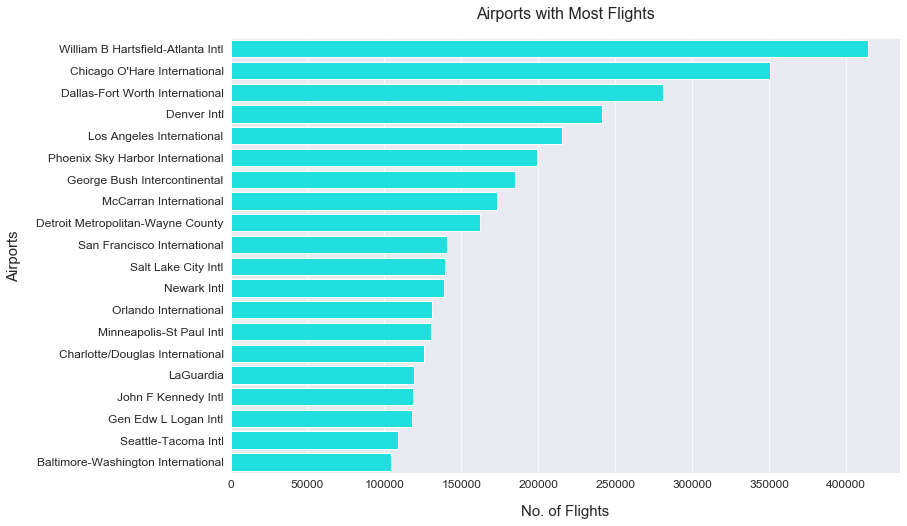

In [15]:
terminal=pd.DataFrame()
terminal[['Origin','airline','Cancelled', 'ArrDelay', 'DepDelay']] = df[['Origin', 'Description',
                                                                         'Cancelled','ArrDelay', 'DepDelay']]
terminal=pd.merge(terminal, airports, left_on='Origin', right_on='iata', how='left')

plt.figure(figsize=(12,8))

sns.barplot(x=terminal.airport.value_counts()[:20], 
            y=terminal.airport.value_counts().index[:20], palette=["aqua"])

plt.title("Airports with Most Flights", fontsize=16, y=1.03)
plt.xlabel('No. of Flights', fontsize=15, labelpad=15)
plt.ylabel('Airports',  fontsize=15,labelpad=15)


plt.xticks(fontsize=12) 
plt.yticks(fontsize=12);

- There is clear differentiation of flight quantity among airports also. Most Popular airports in terms of flight quantity are William B Hartsfield-Atlanta Intl, Chicago O'Hare International, Dallas-Fort Worth International, Denver Intl and so on. 

### How are the flights and airports distributed across US states?

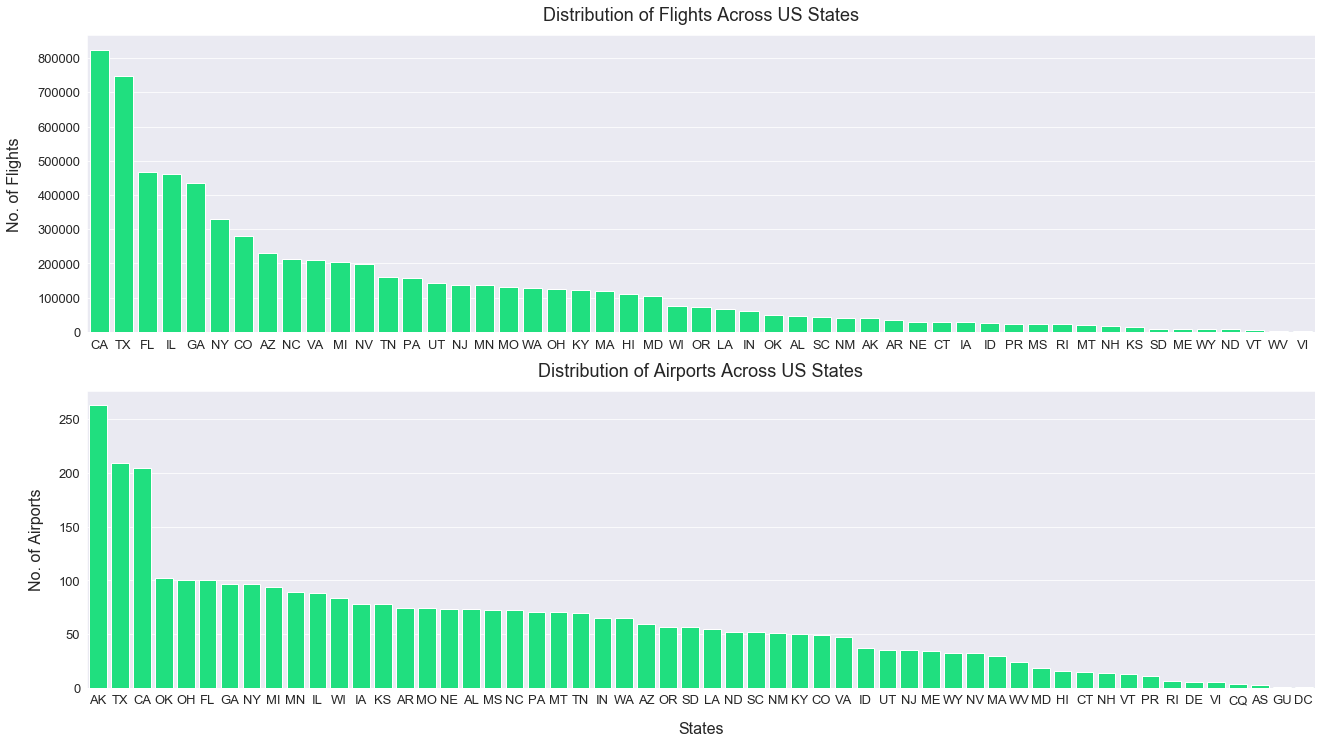

In [16]:
plt.subplots(figsize=(22,12))

plt.subplot(2,1,1)
sns.barplot(y=terminal.state.value_counts(), 
            x=terminal.state.value_counts().index, palette=["springgreen"])

plt.title("Distribution of Flights Across US States", fontsize=18, y=1.03)
plt.ylabel('No. of Flights',  fontsize=16,labelpad=15)

plt.xticks(fontsize=13) 
plt.yticks(fontsize=13)

plt.subplot(2,1,2)

sns.barplot(y=airports.state.value_counts(), 
            x=airports.state.value_counts().index, palette=["springgreen"])

plt.title("Distribution of Airports Across US States", fontsize=18, y=1.03)
plt.xlabel('States', fontsize=16, labelpad=15)
plt.ylabel('No. of Airports',  fontsize=16,labelpad=15)

plt.xticks(fontsize=13) 
plt.yticks(fontsize=13);

- There is clear difference of flights and airports quantity among US States, with states CA,TX,FL,IL,GA,NY handlinng most of the flight traffic. 
- State AK has most no. of airports but a tiny no. of flights are scheduled here.

### Which months, days of the month and days of the week were the busiest for airlines?

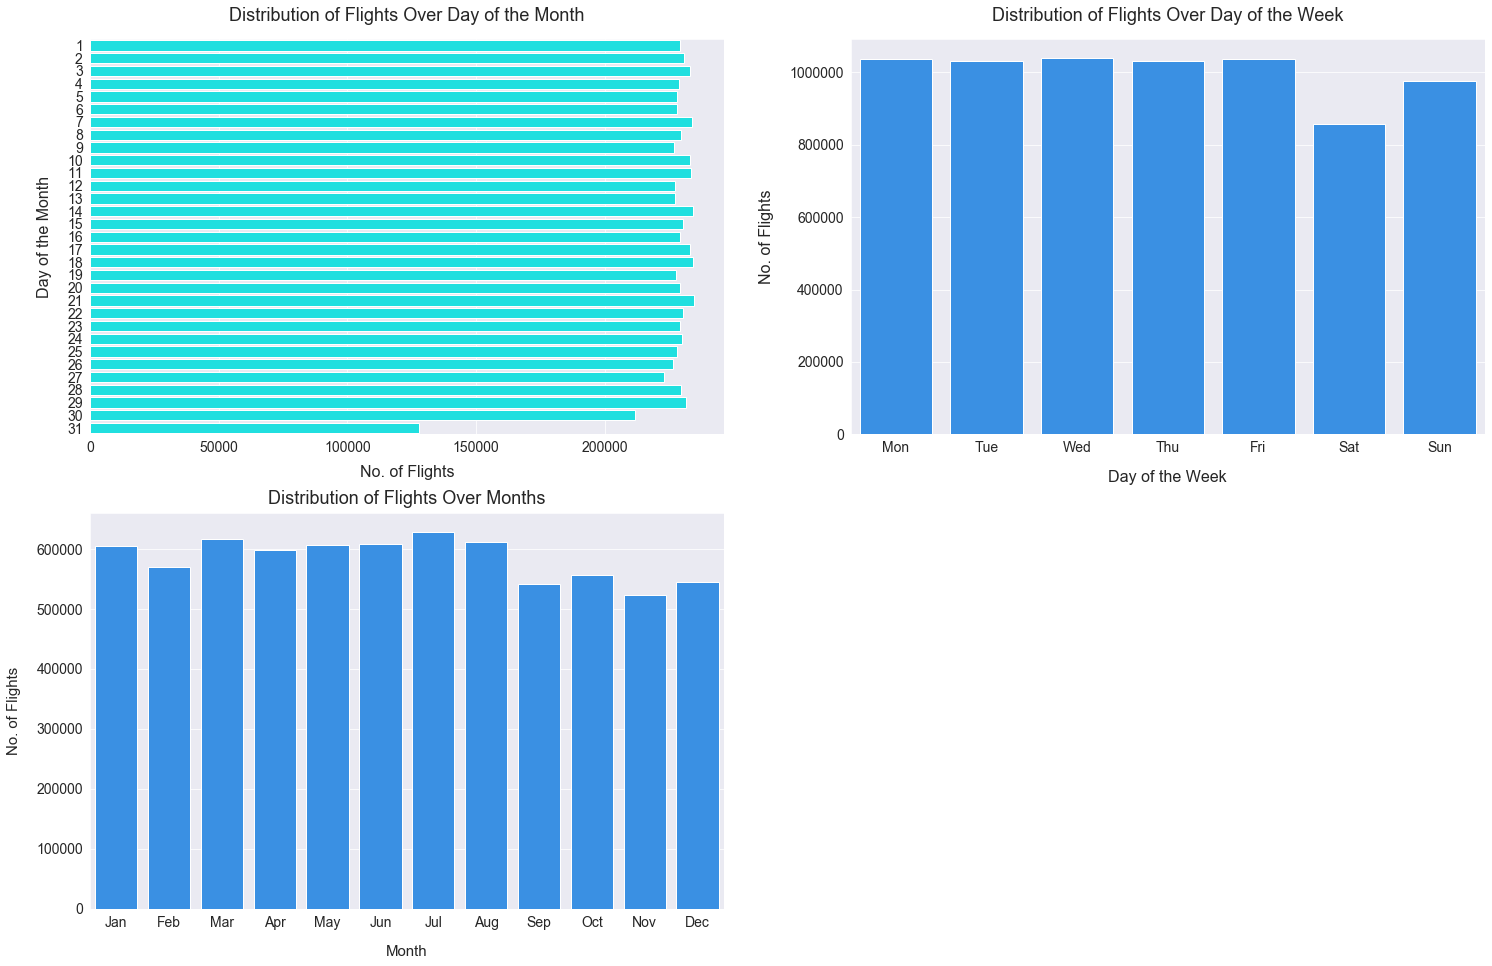

In [17]:
plt.subplots(figsize=(25,16))

plt.subplot(2,2,1)
sns.countplot(data=df, y='DayofMonth', palette=["aqua"])

plt.title("Distribution of Flights Over Day of the Month", fontsize=18, y=1.03)
plt.ylabel('Day of the Month', fontsize=16, labelpad=15)
plt.xlabel('No. of Flights',  fontsize=16,labelpad=10)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14);


plt.subplot(2,2,2)
sns.countplot(data=df, x='DayOfWeek', palette=["dodgerblue"])

plt.title("Distribution of Flights Over Day of the Week", fontsize=18, y=1.03)
plt.xlabel('Day of the Week', fontsize=16, labelpad=15)
plt.ylabel('No. of Flights',  fontsize=16,labelpad=15)
locs=[0,1,2,3,4,5,6]
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(fontsize=14, ticks=locs, labels=dow_names ) 
plt.yticks(fontsize=14)


plt.subplot(2,2,3)
sns.countplot(data=df, x='Month', palette=["dodgerblue"])

plt.title("Distribution of Flights Over Months", fontsize=18, y=1.01)
plt.xlabel('Month', fontsize=15, labelpad=15)
plt.ylabel('No. of Flights',  fontsize=15,labelpad=15)
locs=[0,1,2,3,4,5,6,7,8,9,10,11]
month_names = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(fontsize=14, ticks=locs, labels=month_names) 
plt.yticks(fontsize=14);

- There is no difference in the flight quantity over days of the month except at the end of the month, especially on the 31st where the flight quantity is nearly the half of any other day of the month.
- Further, flight quantity is equally distributed over day of the week, though sees a slight dip on Saturday and Sunday.
- Month of July seems to have highest flight quantity and it decreases thereafter in the later months of the year.

### At what time of the day flights run the most, AM or PM?

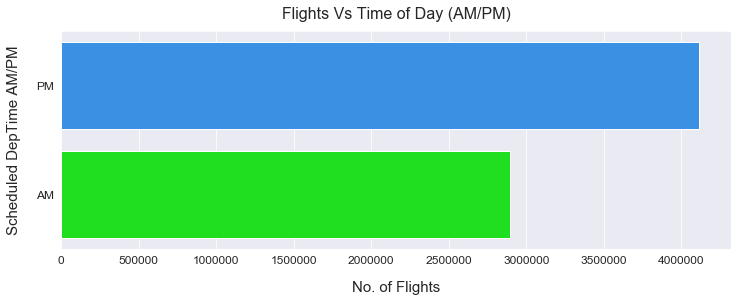

In [18]:
# let's lable the CRSDepTime as AM or PM.
def AM_PM(x):
    if x >= pd.to_timedelta('12:00:00') and x < pd.to_timedelta('24:00:00') :
        return 'PM'
    elif x <pd.to_timedelta('12:00:00') or x == pd.to_timedelta('24:00:00'):
        return 'AM'
    else:
        return x
        
df['CRSDepTime_AM/PM']=df.CRSDepTime.apply(AM_PM)


plt.figure(figsize=(12,4))
sns.countplot(data=df, y='CRSDepTime_AM/PM', palette=["dodgerblue","lime"])

plt.title("Flights Vs Time of Day (AM/PM)", fontsize=16, y=1.03)
plt.xlabel('No. of Flights', fontsize=15, labelpad=15)
plt.ylabel('Scheduled DepTime AM/PM',  fontsize=15,labelpad=15)


plt.xticks(fontsize=12) 
plt.yticks(fontsize=12);

- Clearly, almost 60% of the flights run after Mid-day (12:00PM) and 40% before Mid-day.

### What is the distribution of distance covered by the flights?

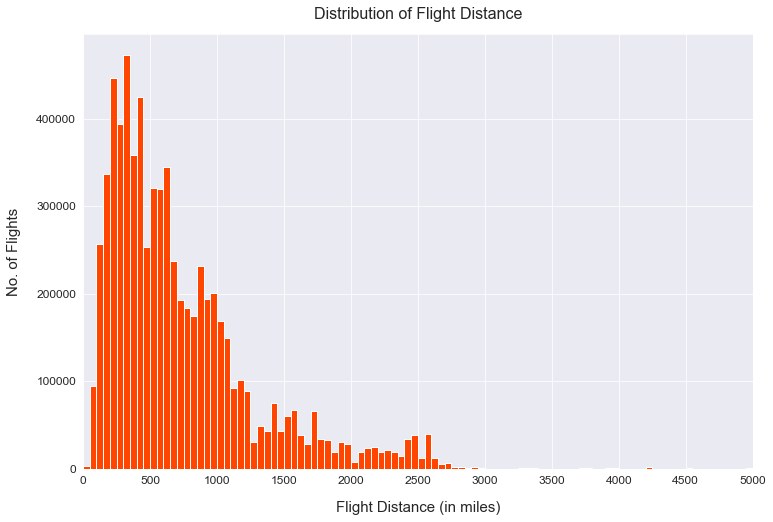

In [19]:
plt.figure(figsize=(12,8))

bin_edges=np.arange(0, df.Distance.max()+100, 50)
plt.hist(data=df, x='Distance', bins=bin_edges, rwidth=1, color='orangered')

plt.xticks(np.arange(0, df.Distance.max()+100, 500), fontsize=12)
plt.yticks(fontsize=12);
plt.xlim([0,5000])

plt.title("Distribution of Flight Distance", fontsize=16, y=1.02)
plt.xlabel('Flight Distance (in miles)', fontsize=15, labelpad=15)
plt.ylabel('No. of Flights',  fontsize=15,labelpad=15);

- We have a right skewed distribution for flight distance, with mode at around 300 km, mean at around 700 km and median at around 500 km.  

### What is the distribution of airtime of flights?

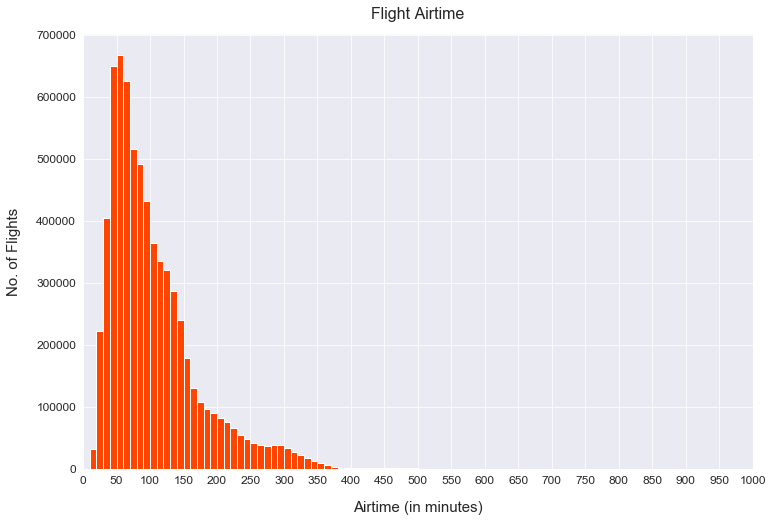

In [20]:
plt.figure(figsize=(12,8))

bin_edges=np.arange(0, df.AirTime.max()+50, 10)
plt.hist(data=df, x='AirTime', bins=bin_edges, rwidth=1, color='orangered')

plt.xticks(np.arange(0, df.AirTime.max()+50, 50), fontsize=12)
plt.yticks(fontsize=12);
plt.xlim(0, 1000);

plt.title("Flight Airtime", fontsize=16, y=1.02)
plt.xlabel('Airtime (in minutes)', fontsize=15, labelpad=15)
plt.ylabel('No. of Flights',  fontsize=15,labelpad=15);

- Airtime is right-skewed and the shape of distribution is similar to that of distance, with mode at around 75 minutes, mean at around 120 minutes and median at around 100 minutes. 

###  What's the cancellation rate of flights and what contributes to the cancellations most?

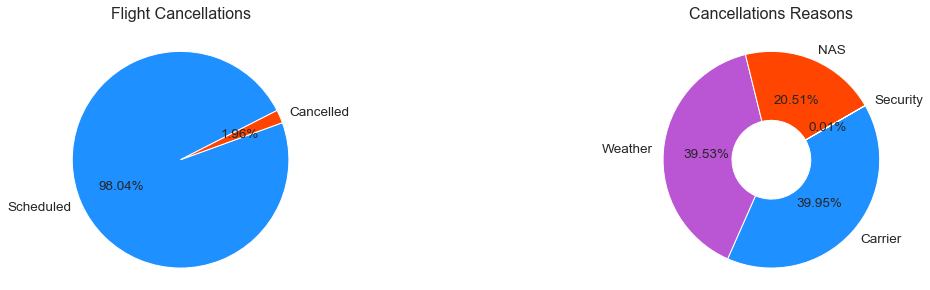

In [21]:
plt.subplots(figsize=(15,5))

plt.subplot(1,3,1)
plt.pie(df['Cancelled'].value_counts(), labels = ['Scheduled', 'Cancelled'], colors=['dodgerblue', 'orangered'],
        startangle = 20, counterclock = False,radius=1.1, autopct='%.2f%%', textprops={'fontsize': 13.5});

plt.title("Flight Cancellations", fontsize=16, y=1.05)

plt.subplot(1,3,3)
plt.pie(df['CancellationCode'].value_counts(), labels=['Carrier','Weather', 'NAS', 'Security'],
        labeldistance=1.1, colors=['dodgerblue','mediumorchid', 'orangered','lime'], startangle = 30,radius=1.1,
        counterclock = False, autopct='%.2f%%', textprops={'fontsize': 13.5}, wedgeprops = {'width': 0.7});

plt.title("Cancellations Reasons", fontsize=16, y=1.05);

- 1,37434 flights (1.96%) were cancelled in the year 2008, weather being the highest contributing factor (39.53%), followed by Carrier, NAS (National Airspace System) and Security.  

### Which month, day of the month or day of the week has most concellations?

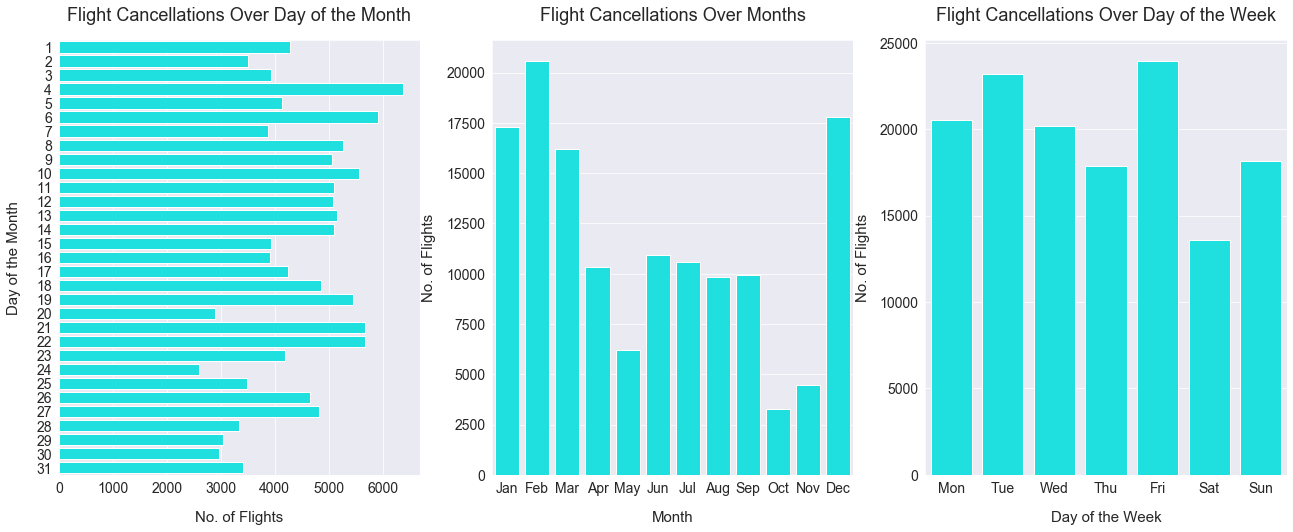

In [22]:
plt.subplots(figsize=(22,8))

plt.subplot(1,3,1)
sns.countplot(data=df[df['Cancelled']==1], y='DayofMonth', palette=["aqua"])

plt.title("Flight Cancellations Over Day of the Month", fontsize=18, y=1.03)
plt.ylabel('Day of the Month', fontsize=15, labelpad=15)
plt.xlabel('No. of Flights',  fontsize=15,labelpad=15)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14);

plt.subplot(1,3,2)
sns.countplot(data=df[df['Cancelled']==1], x='Month', palette=["aqua"])

plt.title("Flight Cancellations Over Months", fontsize=18, y=1.03)
plt.xlabel('Month', fontsize=15, labelpad=15)
plt.ylabel('No. of Flights',  fontsize=15,labelpad=10)
locs=[0,1,2,3,4,5,6,7,8,9,10,11]
month_names = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(fontsize=14, ticks=locs, labels=month_names) 
plt.yticks(fontsize=14)


plt.subplot(1,3,3)
sns.countplot(data=df[df['Cancelled']==1], x='DayOfWeek', palette=["aqua"])

plt.title("Flight Cancellations Over Day of the Week", fontsize=18, y=1.03)
plt.xlabel('Day of the Week', fontsize=15, labelpad=15)
plt.ylabel('No. of Flights',  fontsize=15,labelpad=10)
locs=[0,1,2,3,4,5,6]
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(fontsize=14, ticks=locs, labels=dow_names ) 
plt.yticks(fontsize=14);

- Day 4 of the month appears to have the most cancellations, while day 24 of the month has least cancellations.
- Also, the second half of the month have lesser cancellations than the first half of the month. 
- There is clear differentiation of flight cancellations over months, with month of Feb having the highest cancellations and Oct the least. And the the differnece is big upwards of 15000 flights cancellations.  
- In case of day of the week, weekdays has more cancellations that weekends. Friday sees the most cancellations and Saturday the least.

### Which airline contributes the most to cancellations?

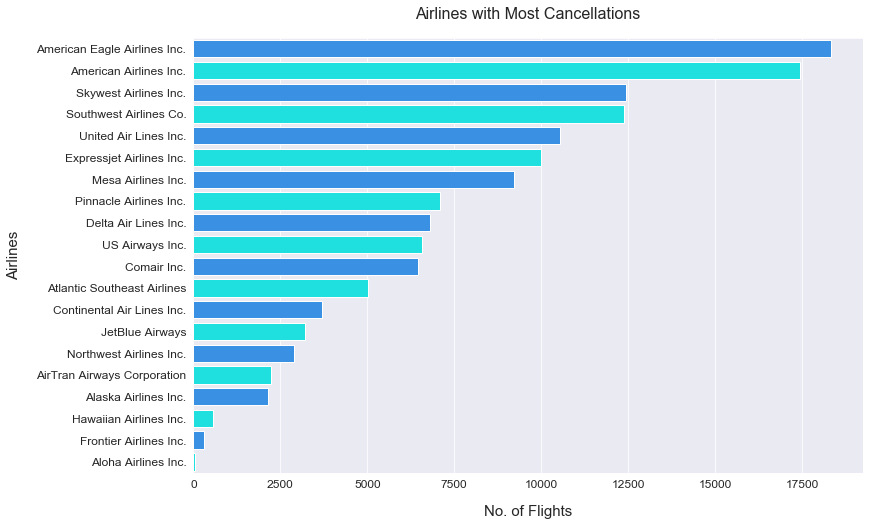

In [23]:
plt.figure(figsize=(12,8))
sns.countplot(data=df[df['Cancelled']==1], y='Description', 
              order= df[df['Cancelled']==1].Description.value_counts().index, 
              palette=["dodgerblue", "aqua"])


plt.title("Airlines with Most Cancellations", fontsize=16, y=1.03)
plt.xlabel('No. of Flights', fontsize=15, labelpad=15)
plt.ylabel('Airlines',  fontsize=15,labelpad=15)

plt.xticks(fontsize=12, rotation=0) 
plt.yticks(fontsize=12);

- Clearly, airlines with highest cancellations: American EAgle Airlines Inc, American Airlines Inc, Skywest Airlines Inc. and so on.

###  Which airports tend to have most cancellations?

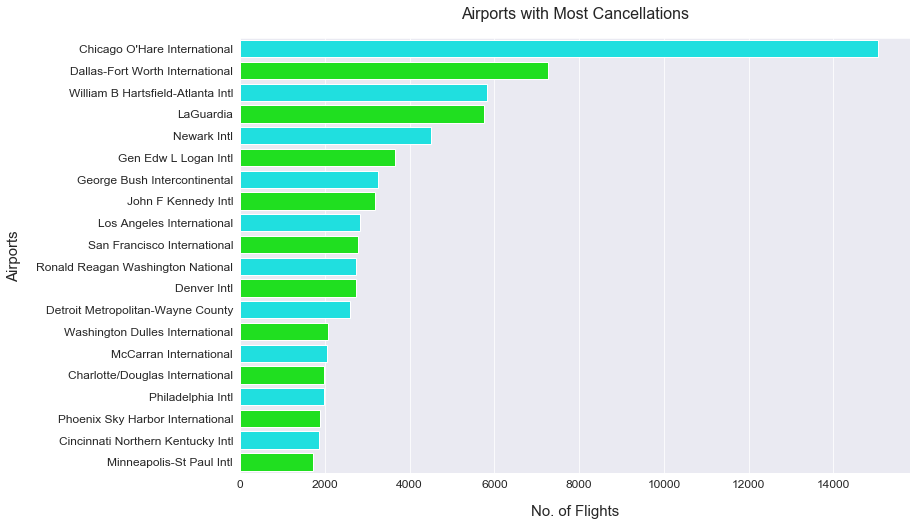

In [24]:
plt.figure(figsize=(12,8))

sns.countplot(data=terminal[terminal['Cancelled']==1], y='airport', 
              order= terminal[terminal['Cancelled']==1].airport.value_counts().index[:20],
              palette=["aqua","lime"] )


plt.title("Airports with Most Cancellations", fontsize=16,  y=1.03)
plt.xlabel('No. of Flights', fontsize=15, labelpad=15)
plt.ylabel('Airports',  fontsize=15,labelpad=15)

plt.xticks(fontsize=12, rotation=0) 
plt.yticks(fontsize=12);

- As we can see, airports with highest flight cancellations: Chicago O'Hare International, Dallas-Fort Worthe International, LaGaurdia and so on. 

### How's the distribution of departure delay of flights?

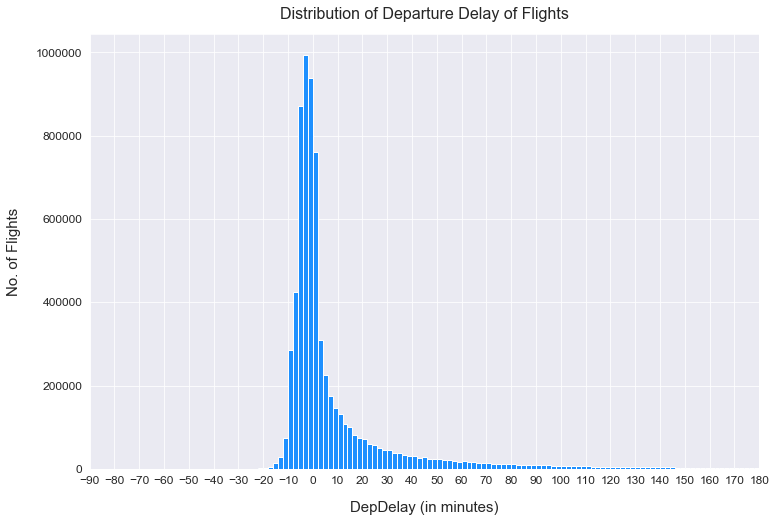

In [25]:
plt.figure(figsize=(12,8))

bin_edges=np.arange(df.DepDelay.min(), df.DepDelay.max()+10, 2)
plt.hist(data=df, x='DepDelay', bins=bin_edges, rwidth=1, color='dodgerblue')

plt.xticks(np.arange(-90, df.DepDelay.max()+10, 10), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-90, 180);

plt.title("Distribution of Departure Delay of Flights", fontsize=16, y=1.02)
plt.xlabel('DepDelay (in minutes)', fontsize=15, labelpad=15)
plt.ylabel('No. of Flights',  fontsize=15,labelpad=15);

- This looks like a right-skewed distribution with mode at around 0 minute, mean at around 10 minutes and median at around 5 minutes.

### How's the distribution of Arrival Delay of flights?

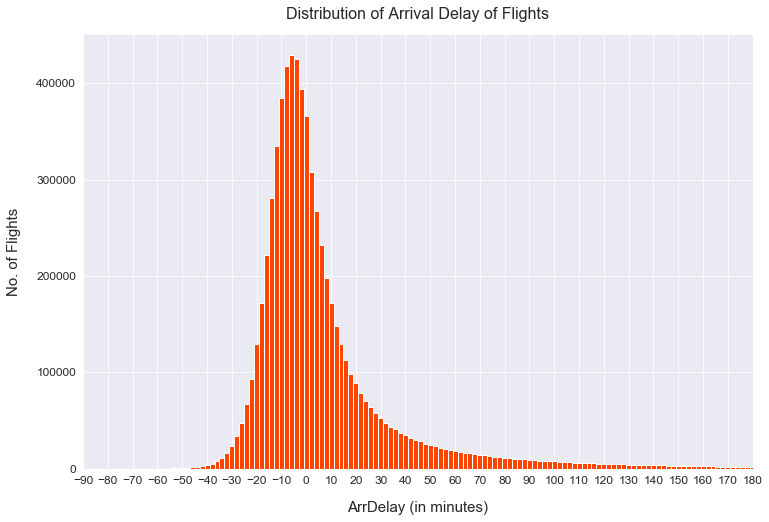

In [26]:
plt.figure(figsize=(12,8))

bin_edges=np.arange(df.ArrDelay.min(), df.ArrDelay.max()+10, 2)
plt.hist(data=df, x='ArrDelay', bins=bin_edges, rwidth=1, color='orangered')

plt.xticks(np.arange(-90, df.ArrDelay.max()+10, 10), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-90, 180);

plt.title("Distribution of Arrival Delay of Flights", fontsize=16, y=1.02)
plt.xlabel('ArrDelay (in minutes)', fontsize=15, labelpad=15)
plt.ylabel('No. of Flights',  fontsize=15,labelpad=15);

- We have a nearly a uniform distribution for arrival delay of flights with center at 0 minute. 
- Also, the distribution tails towards negative values as well i.e many flights have arrived earlier than scheduled. 

### How's the distribution of elapsed time delay?  (The  Airline's SLA)

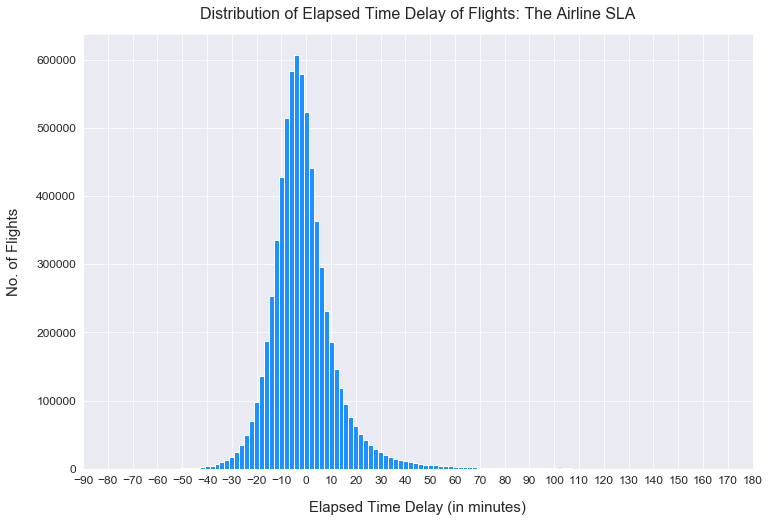

In [27]:
# elapsed time delay = ActualElapsedTime -  Scheduled Elapsed Time

df['ActualElapsedTime']=df['ActualElapsedTime'].apply(lambda x: int(x) if pd.notnull(x) else x)
df['CRSElapsedTime']=df['CRSElapsedTime'].apply(lambda x: int(x) if pd.notnull(x) else x)

df['delay_elapsed']= df['ActualElapsedTime'] - df['CRSElapsedTime']

plt.figure(figsize=(12,8))

bin_edges=np.arange(df.delay_elapsed.min(), df.delay_elapsed.max()+10, 2)
plt.hist(data=df,x='delay_elapsed', bins=bin_edges, rwidth=1, color='dodgerblue')

plt.xticks(np.arange(-90, df.delay_elapsed.max()+10, 10), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-90, 180);

plt.title("Distribution of Elapsed Time Delay of Flights: The Airline SLA", fontsize=16, y=1.02)
plt.xlabel('Elapsed Time Delay (in minutes)', fontsize=15, labelpad=15)
plt.ylabel('No. of Flights',  fontsize=15,labelpad=15);

- We're again looking at a nearly uniform normal distribution with center at less than 0 minute (which is expected  from the airlines).  

<a id='bivariate'></a>
### Bivariate Analysis:

### Do all the airlines reach all the US states?

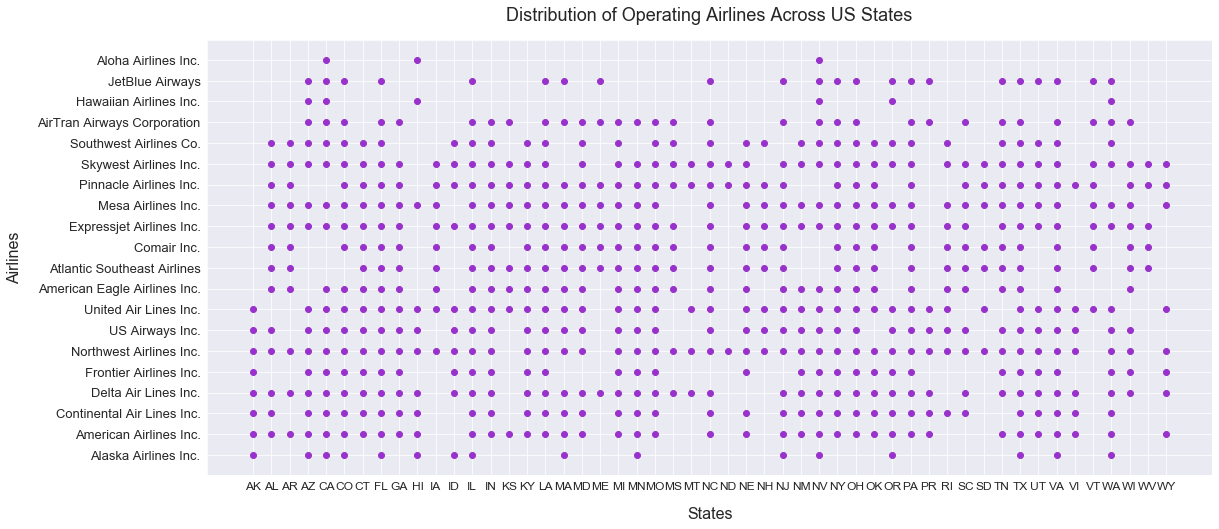

In [28]:
dump = terminal.groupby(['state', 'airline'], as_index=False).count()[['state','airline']]

plt.figure(figsize=[18,8])
plt.scatter(dump.state,dump.airline, color='darkorchid')

plt.title("Distribution of Operating Airlines Across US States", fontsize=18, y=1.03)
plt.xlabel('States', fontsize=16, labelpad=15)
plt.ylabel('Airlines',  fontsize=16,labelpad=15)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=13);

- That's one nicely distributed scatter plot above, i.e most of the airlines reach most of the states.

### Do all the airlines have movement at all the US airports?

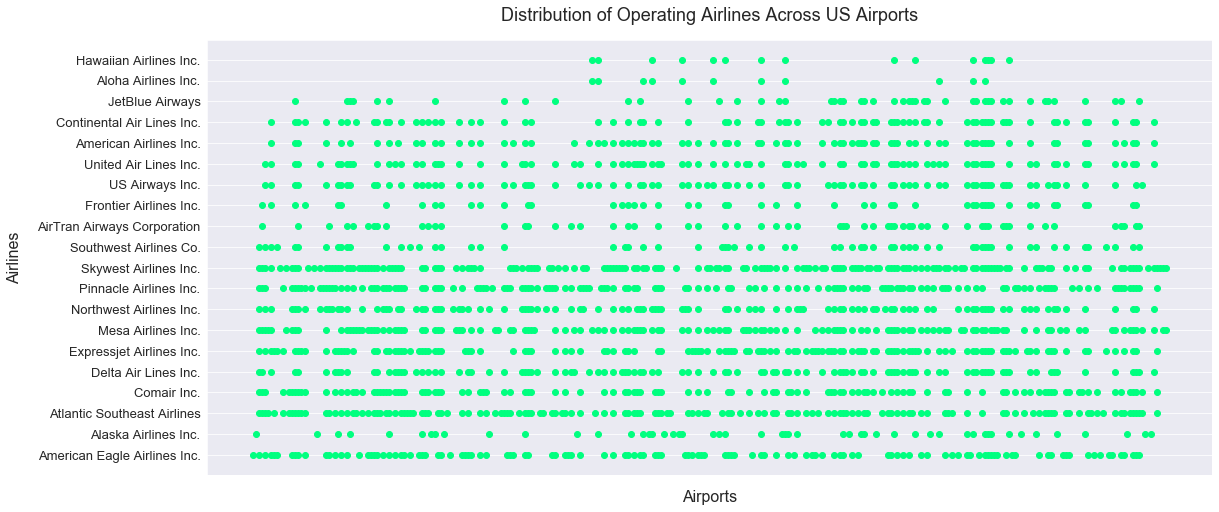

In [29]:
dump3 = terminal.groupby(['airport', 'airline'], as_index=False).count()[['airport','airline']]

plt.figure(figsize=[18,8])
ax=plt.scatter(dump3.airport,dump3.airline, color='springgreen')
ax.axes.xaxis.set_ticks([])

plt.title("Distribution of Operating Airlines Across US Airports", fontsize=18, y=1.03)
plt.xlabel('Airports', fontsize=16, labelpad=15)
plt.ylabel('Airlines',  fontsize=16,labelpad=15)
plt.yticks(fontsize=13);

- A heavily distributed scatter plot, almost all of the airports have flights scheduled from all of the airlines.  

### What time of the day tends to have more cancellations?

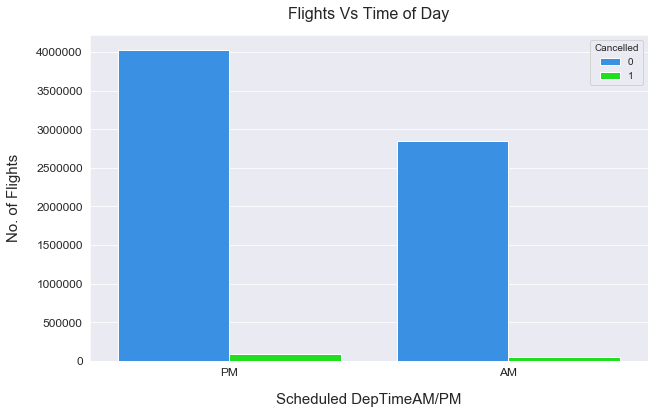

In [30]:
plt.figure(figsize=(10,6))
gt = sns.countplot(x=df["CRSDepTime_AM/PM"], hue=df["Cancelled"], palette=["dodgerblue","lime"])
gt.set_yscale("linear")

plt.title("Flights Vs Time of Day", fontsize=16, y=1.03)
plt.ylabel('No. of Flights', fontsize=15, labelpad=15)
plt.xlabel('Scheduled DepTimeAM/PM',  fontsize=15,labelpad=15)

plt.xticks(fontsize=12) 
plt.yticks(fontsize=12);

- Most flights run after Mid-day, they also get cancelled the most in the same proportion as that of the flights that run before mid-day.  

### Is there any significant relationship among the numerical variables of a flight?

C:\Users\Piyush\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Piyush\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


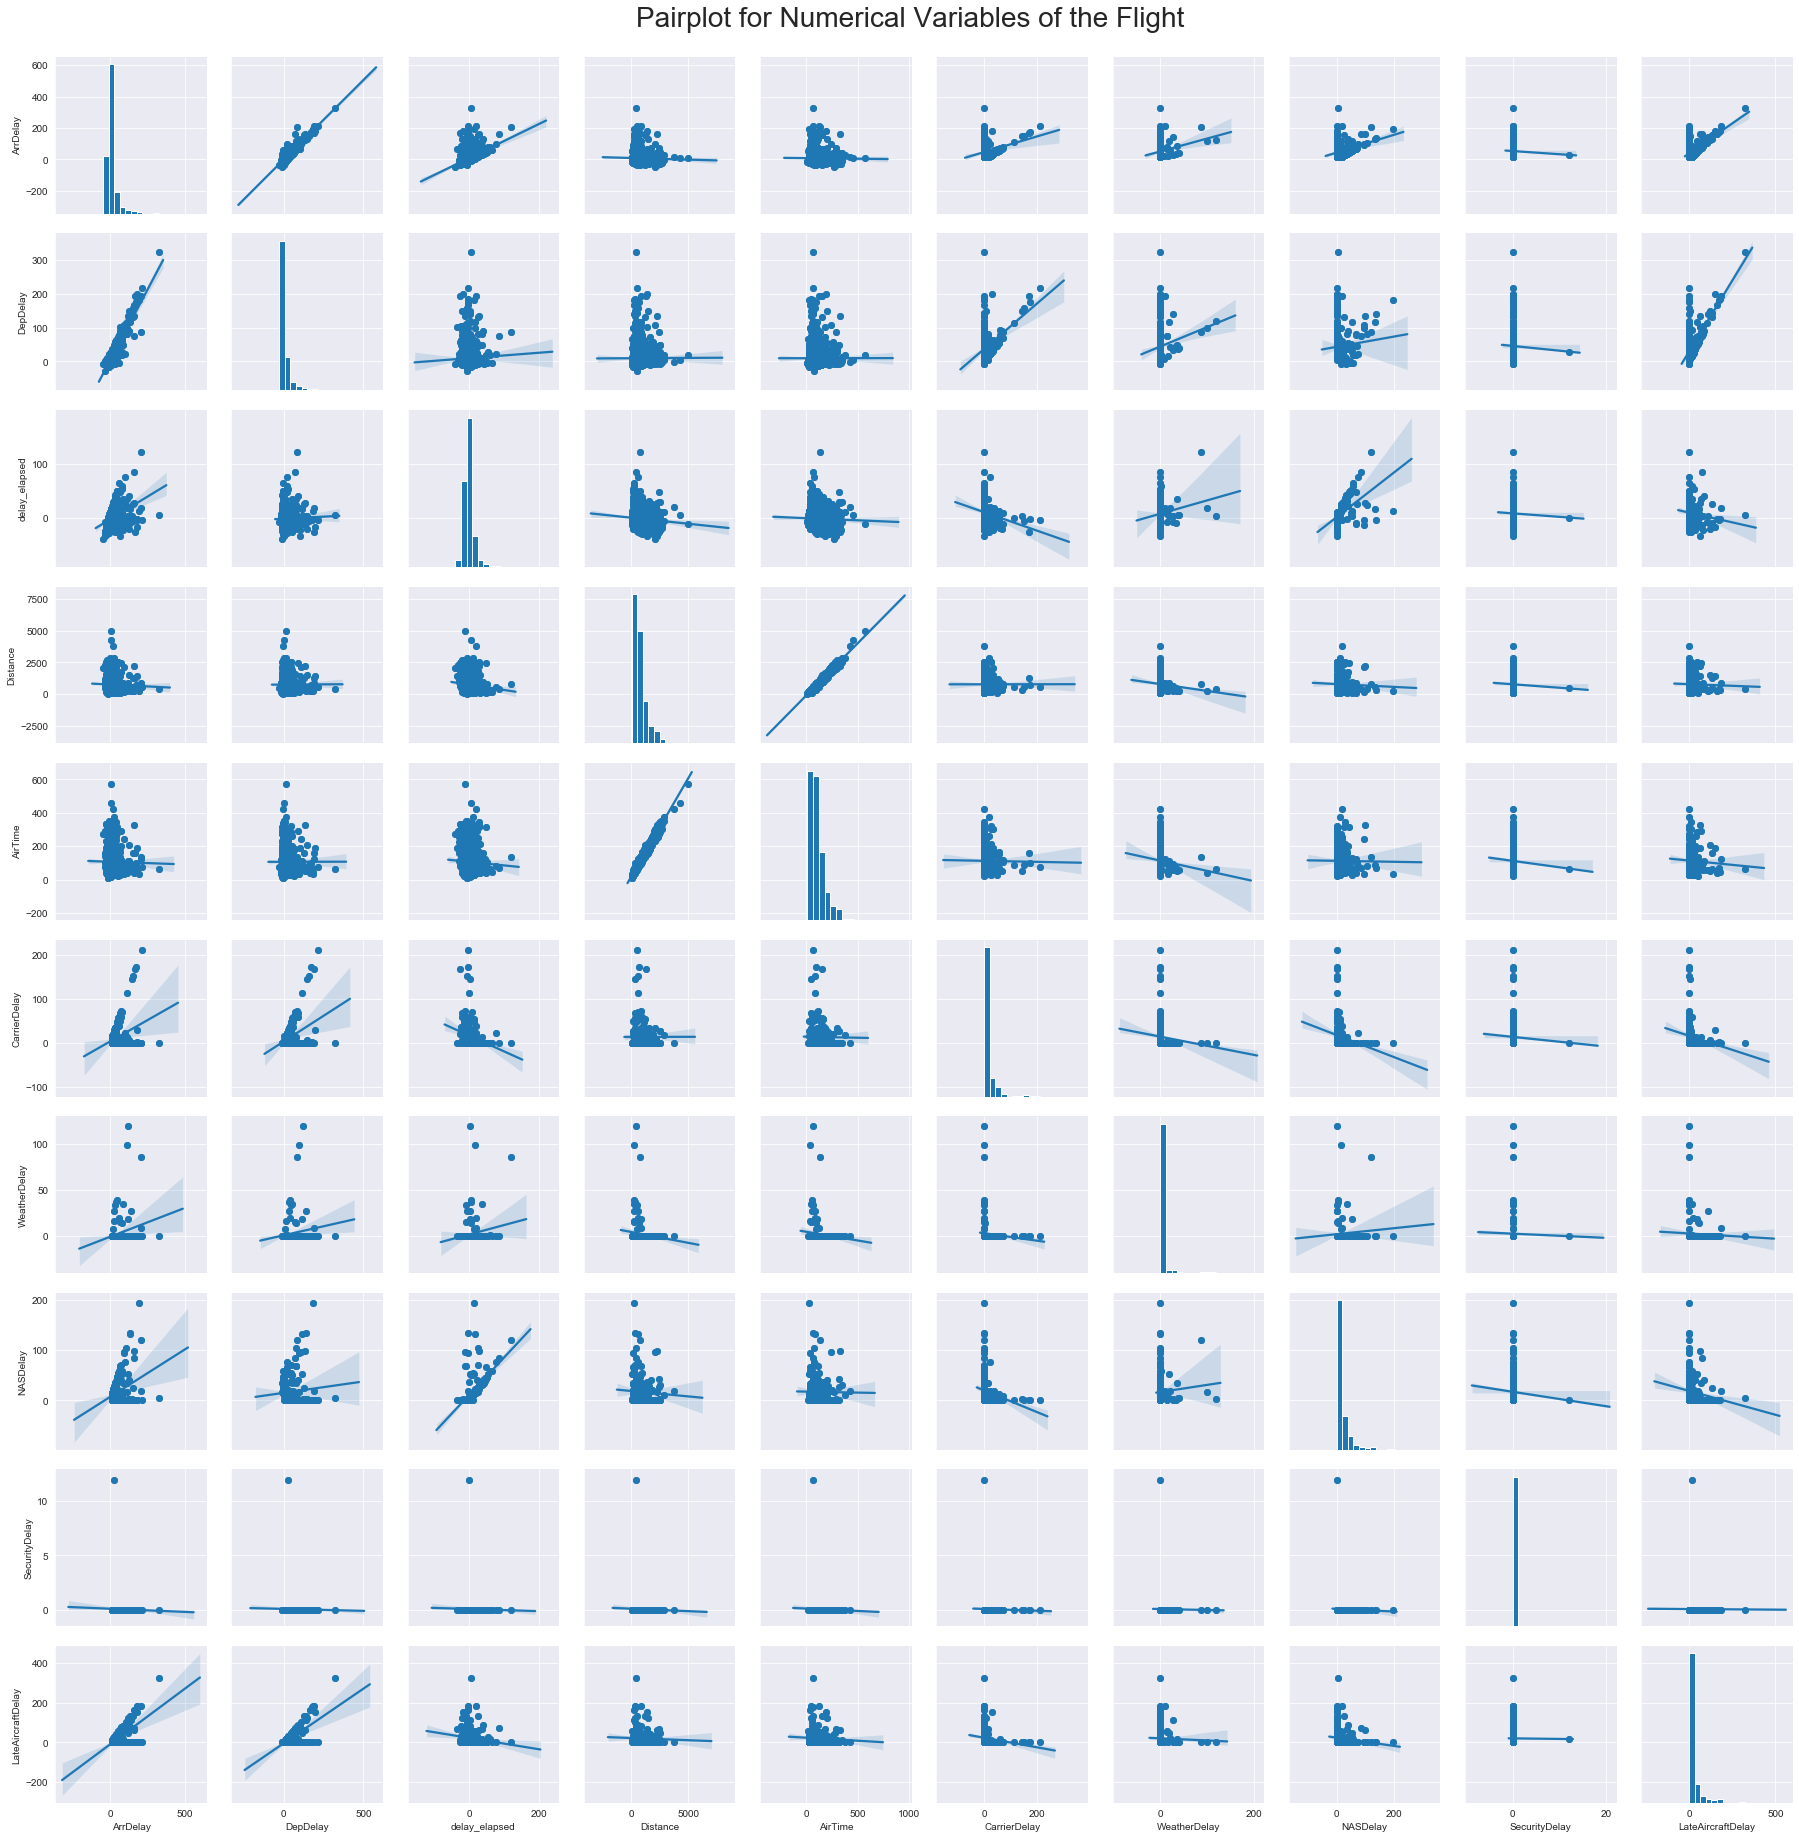

In [31]:
# sampling 1000 flights from the dataset for fast rendering.
samples = df.sample(1000, replace=False, random_state=42)

g = sns.pairplot(data=samples, vars=["ArrDelay","DepDelay","delay_elapsed","Distance","AirTime","CarrierDelay",
                "WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"], 
                 kind='reg', palette=['darkorchid', 'lime'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

sns.set(font_scale=1.3)
plt.suptitle('Pairplot for Numerical Variables of the Flight', fontsize=28, y=1.02);

- Security delay has the least frequency of occurence and almost no or weaker effect on other numerical variables of the flight.
- We have strong positive correlation between Distance and Airtime as expected. 
- From the slope of the regression line, it can be inferred that, weather delay adds to the arrival delay more than any other delay factors, this effect is even greater in case of departure delay. 
- NAS delay add more to delay_elapsed than any other delay factor. 

<a id='multivariate'></a>
### Multivariate Analysis:

### How's the correlation factor among numerical variables of the flight?

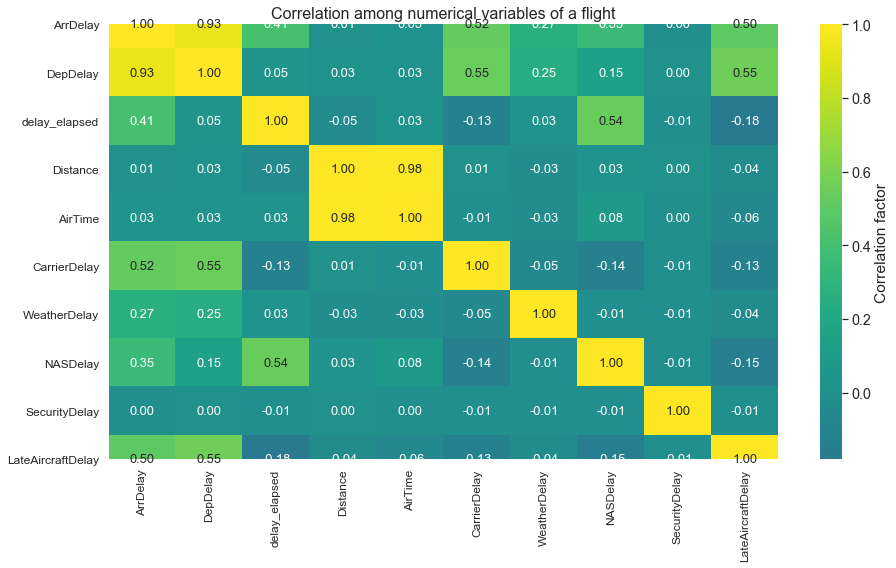

In [32]:
plt.figure(figsize=[15,8])


sns.heatmap(df[["ArrDelay","DepDelay","delay_elapsed","Distance","AirTime","CarrierDelay",
                "WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"]].corr(),
            annot = True, annot_kws={"fontsize":13}, cbar_kws={'label': 'Correlation factor'},
            fmt = ".2f", cmap = 'viridis', center = 0)

plt.title("Correlation among numerical variables of a flight", fontsize=16, y=1.02)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
sns.set(font_scale=1.1);

### Which type of delay occurs the most, if a flight gets delayed?

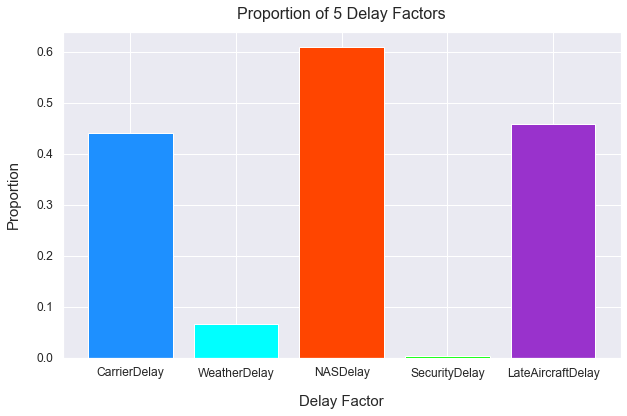

In [33]:
# we have so many null values for each type of delay, we'll exclude them entirely to estimate the proportion. 

dump2=df[pd.notnull(df['CarrierDelay']) & 
        pd.notnull(df['WeatherDelay']) &
        pd.notnull(df['NASDelay']) &
        pd.notnull(df['SecurityDelay']) &
        pd.notnull(df['LateAircraftDelay'])]

a=[]
for i in ['CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']:
    a.append(dump2[dump2[i]!=0].shape[0]/dump2.shape[0])

plt.figure(figsize=[10,6])
   
labels=['CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
plt.bar([1,2,3,4,5],a, tick_label=labels,  color=['dodgerblue','aqua','orangered', 'lime','darkorchid' ]);

plt.title("Proportion of 5 Delay Factors", fontsize=16, y=1.02)
plt.xlabel('Delay Factor', fontsize=15, labelpad=15)
plt.ylabel('Proportion',  fontsize=15,labelpad=15);

- We might have a simpson's paradox here, as National Airspace System (NAS) delay happens more frequently than weather or security delay. 

### How's the geographical distribution of departure delay of flights?  

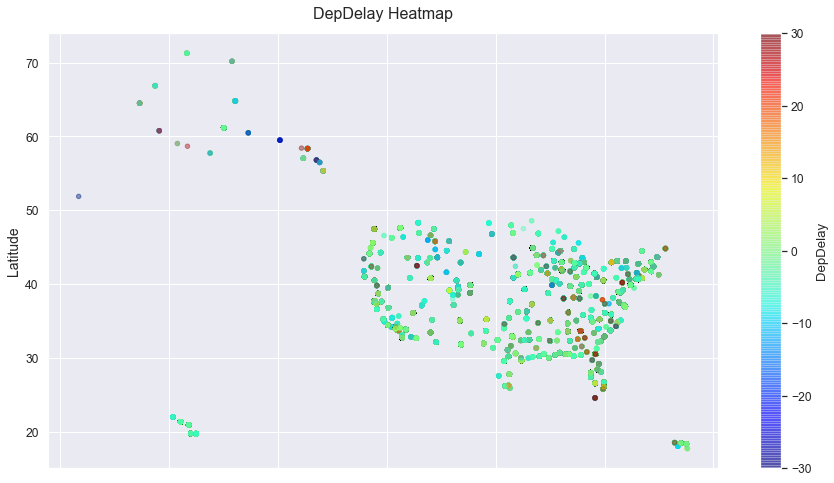

In [34]:
# let's draw the heatmap of DepDelay on US map.

# Bounding the departure delays to -30 and +30 mins. 
def bound_DepDelay(x):
    max_delay, min_delay = 30, -30
    if(x>max_delay): 
        x=max_delay
    elif(x<min_delay):
        x=min_delay
    return x

# Sampling 100000 observations from the dataset for fast rendering.  
samples_n = terminal.sample(100000, replace=False, random_state=42)
samples_n.DepDelay = samples_n.DepDelay.apply(lambda i: bound_DepDelay(i))

samples_n.plot(kind='scatter',x='long',y='lat', c='DepDelay', 
               alpha=0.4, cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,8))

plt.title("DepDelay Heatmap", fontsize=16, y=1.02)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show();

- Depature delay on US map. Find your spot on the map. :)

### How's the geographical distribution of arrival delay of flights?

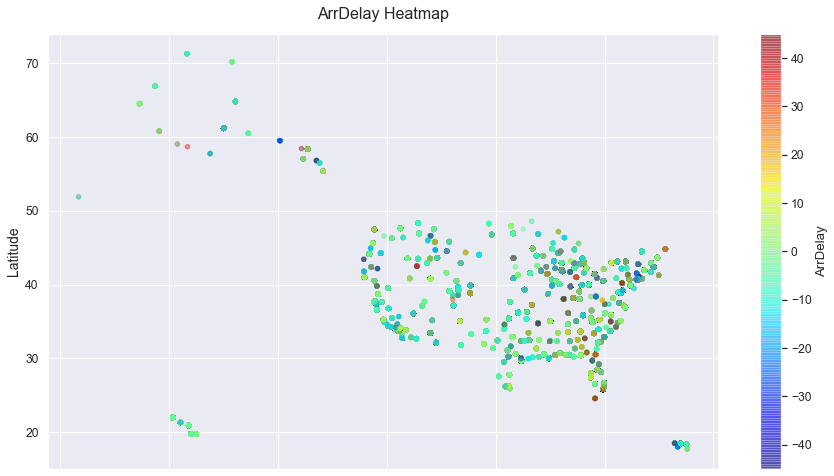

In [35]:
# let's draw the heatmap of ArrDelay on US map.

# Bounding the Arrival delays to -45 and +45 mins. 

def bound_ArrDelay(x):
    max_delay, min_delay = 45, -45
    if(x>max_delay): 
        x=max_delay
    elif(x<min_delay):
        x=min_delay
    return x

# Sampling 100000 observations from the dataset for fast rendering.  
samples_n = terminal.sample(100000, replace=False, random_state=42)
samples_n.ArrDelay = samples_n.ArrDelay.apply(lambda i: bound_ArrDelay(i))

samples_n.plot(kind='scatter',x='long',y='lat', c='ArrDelay', 
               alpha=0.4, cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,8))

plt.title("ArrDelay Heatmap", fontsize=16, y=1.02)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show();

- Arrivale Delay on US map.